In [1]:
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.optimizers import Adam

%matplotlib inline

np.random.seed(42)

2025-02-26 19:18:19.106105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-26 19:18:19.913432: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-02-26 19:18:19.913570: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-02-26 19:18:19.913581: W tensorflow/compiler/tf2tensorrt/util

In [2]:
import h5py
with h5py.File("data/M01/OP04/good/M01_Aug_2019_OP04_011.h5", "r") as f:
    print(list(f.keys()))
    print(f['vibration_data'][:])

['vibration_data']
[[  -23.    31. -1016.]
 [  -23.    23. -1018.]
 [  -17.    17. -1013.]
 ...
 [   -9.    19. -1030.]
 [   -5.    35. -1016.]
 [  -11.    25. -1020.]]


In [3]:
import h5py
dataset_path = 'data'
samplerate = 2000

# Pattern to match all CSV files
pattern = os.path.join(dataset_path, '*', '*', '*', '*.h5')  

data = []
labels = []

for h5_file in tqdm(glob(pattern)):
    # Extract label from the file path
    label = h5_file.split(os.sep)[-2]
    with h5py.File(h5_file, "r") as f:
        # Convert to numpy array first to check the length
        vibration_data_np = f['vibration_data'][:]

        # Check if the length of the data is at least 10*samplerate
        if not len(vibration_data_np) >= 10 * samplerate:
            continue

        # If so, append the first 10 seconds of data
        data.append(vibration_data_np[:(10 * samplerate)])
        labels.append(0 if label=='bad' else 1)

data = np.array(data)
labels = np.array(labels)

100%|██████████| 1702/1702 [00:19<00:00, 86.08it/s] 


In [4]:
data.shape

(1702, 20000, 3)

In [5]:
downsample_factor = 10
new_shape = data.shape[0], data.shape[1] // downsample_factor, downsample_factor, data.shape[2]

# Downsampling the data
data_sampled = np.mean(data.reshape(new_shape), axis=2)

In [6]:
data_sampled.shape

(1702, 2000, 3)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data_sampled,
                                                    labels,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42,
                                                    stratify=labels)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (1361, 2000, 3)
y_train shape: (1361,)
X_test shape: (341, 2000, 3)
y_test shape: (341,)


In [8]:
# normalize X_train to [0,1] by sklearn.preprocessing.MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])  # 變成 (1000, 3)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)

# 轉回原形狀
X_train = X_train_scaled.reshape(X_train.shape)

In [9]:
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])  # 變成 (1000, 3)
X_test_scaled = scaler.transform(X_test_reshaped)
# 轉回原形狀
X_test = X_test_scaled.reshape(X_test.shape)

In [10]:
X_train.shape

(1361, 2000, 3)

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
import numpy as np

class AutoEncoder(Model):
    def __init__(self, input_shape):
        super().__init__()
        self.input_shape_ = input_shape  # e.g., (2000, 3)
        self.input_layer = Input(shape=input_shape)  # 3D input: (2000, 3)

        # Flatten the input from (2000, 3) to (6000,)
        self.flatten = Flatten()

        # Encoder part
        self.encoder = Sequential([
            Dense(128, activation='relu', name='encoder1'),
            Dense(64, activation='relu', name='encoder2'),
            Dense(32, activation='relu', name='encoder3'),
        ], name='encoder')

        # Decoder part
        self.decoder = Sequential([
            Dense(32, activation='relu', name='decoder1'),
            Dense(64, activation='relu', name='decoder2'),
            Dense(128, activation='relu', name='decoder3'),
            Dense(input_shape[0] * input_shape[1], activation='sigmoid', name='output'),  # 2000 * 3 = 6000
        ], name='decoder')

        # Reshape back to original shape (2000, 3)
        self.reshape = Reshape(input_shape)

    def call(self, inputs):
        flattened = self.flatten(inputs)  # (batch_size, 6000)
        encoded = self.encoder(flattened)  # (batch_size, 32)
        decoded = self.decoder(encoded)    # (batch_size, 6000)
        reconstructed = self.reshape(decoded)  # (batch_size, 2000, 3)
        return reconstructed

# Define input shape based on X_train
input_shape = X_train.shape[1:]  # (2000, 3)

# Instantiate and compile the model
autoencoder = AutoEncoder(input_shape=input_shape)
autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mae')

# Build the model with a sample input
_ = autoencoder(X_train)

# Display the model's architecture
autoencoder.summary()

2025-02-26 19:19:22.930119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-26 19:19:22.938748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-26 19:19:22.939027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-26 19:19:22.939626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild

Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           multiple                  0         
                                                                 
 encoder (Sequential)        (1361, 32)                778464    
                                                                 
 decoder (Sequential)        (1361, 6000)              785488    
                                                                 
 reshape (Reshape)           multiple                  0         
                                                                 
Total params: 1,563,952
Trainable params: 1,563,952
Non-trainable params: 0
_________________________________________________________________


In [12]:
_.shape

TensorShape([1361, 2000, 3])

In [13]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 100
BATCH_SIZE = 32

# 假設 X_train 和 y_train 已經定義
X_train_normal = X_train[np.where(y_train == 1)]

# 定義 Early Stopping 回調
early_stopping = EarlyStopping(
    monitor='val_loss',    # 監控驗證集的損失
    patience=10,          # 如果 10 個 epoch 沒有改善就停止
    restore_best_weights=True,  # 恢復最佳權重
    mode='min'            # 希望損失是最小值
)

# 訓練模型，使用 validation_split 自動切分驗證集
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # 自動從訓練數據中分出 20% 作為驗證集
    shuffle=True,
    callbacks=[early_stopping]  # 添加 early stopping 回調
)

Epoch 1/100


2025-02-26 19:19:57.998823: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f8020011470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-26 19:19:57.998871: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): GRID P40-24Q, Compute Capability 6.1
2025-02-26 19:19:58.004582: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-26 19:19:58.130472: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 [==============================] - 3s 15ms/step - loss: 0.0944 - val_loss: 0.0736
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0495 - val_loss: 0.0330
Epoch 3/100
33/33 [==============================] - 0s 5ms/step - loss: 0.0302 - val_loss: 0.0285
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0287 - val_loss: 0.0283
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0286 - val_loss: 0.0283
Epoch 6/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0286 - val_loss: 0.0283
Epoch 7/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0286 - val_loss: 0.0283
Epoch 8/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0286 - val_loss: 0.0282
Epoch 9/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0286 - val_loss: 0.0283
Epoch 10/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0286 - val_loss: 0.0283
Epoch 11/100
33/33 [

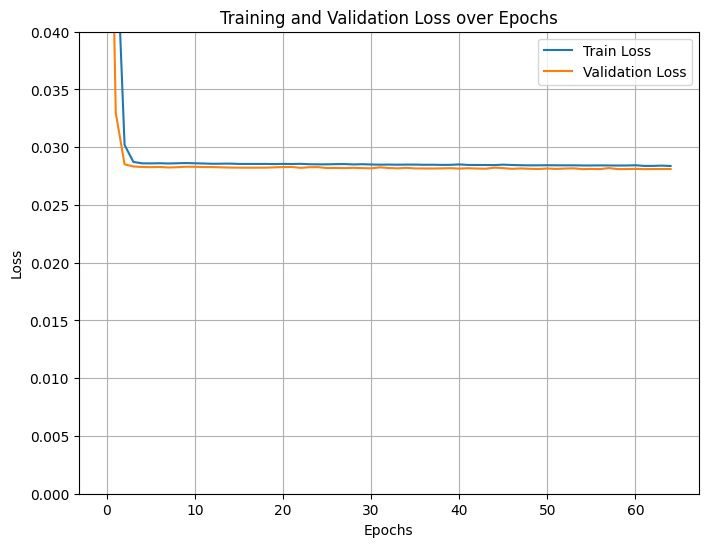

In [17]:
import matplotlib.pyplot as plt

# 提取訓練過程中的損失和驗證損失
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 畫圖
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,0.04)
plt.legend()
plt.grid(True)
plt.show()

In [19]:
X_test.shape

(341, 2000, 3)

41/41 [==============================] - 0s 1ms/step
The prediction loss threshold is less than 0.0021 or more than 0.0081


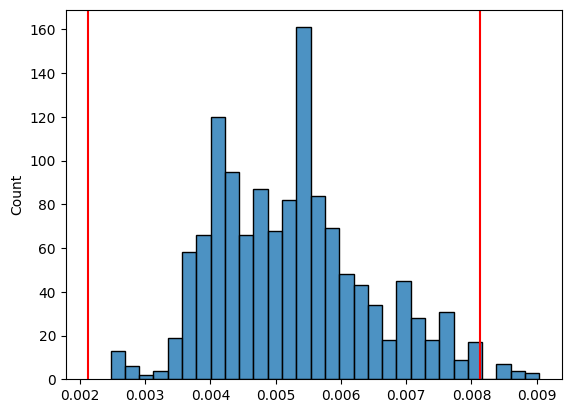

In [40]:
# Predict anomalies/outliers in the training dataset
prediction_X_train_normal = autoencoder.predict(X_train_normal)
# Get the mean absolute error between actual and reconstruction/prediction
prediction_loss = np.mean((X_train_normal - prediction_X_train_normal) ** 2, axis=(1, 2))
# Get the threshold for anomalies/outliers detection using interquartile range
IQR = np.quantile(prediction_loss, 0.75) - np.quantile(prediction_loss, 0.25)
lower_threshold = np.quantile(prediction_loss, 0.25) - 1.5 * IQR
upper_threshold = np.quantile(prediction_loss, 0.75) + 1.5 * IQR
print(f'The prediction loss threshold is less than {lower_threshold:.4f} or more than {upper_threshold:.4f}')
# Visualize the threshold
sns.histplot(prediction_loss, bins=30, alpha=0.8)
plt.axvline(x=lower_threshold, color='red')
plt.axvline(x=upper_threshold, color='red')
plt.show()

In [41]:
# Predict anomalies/outliers in the training dataset
prediction_X_test = autoencoder.predict(X_test)
# Get the mean absolute error between actual and reconstruction/prediction
reconstruction_error_X_test = np.mean((X_test - prediction_X_test) ** 2, axis=(1, 2))

threshold_prediction = np.array([1 if (lower_threshold < i < upper_threshold) else 0 for i in reconstruction_error_X_test])

print(classification_report(y_test, threshold_prediction))

11/11 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.33      0.14      0.20        14
           1       0.96      0.99      0.98       327

    accuracy                           0.95       341
   macro avg       0.65      0.57      0.59       341
weighted avg       0.94      0.95      0.94       341

